# Ensamble: Boosting

Podemos encontrar la documentacion en:  
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing, ensemble

from preprocessing import cargarDatasets
from preprocessing import prepararSet
from preprocessing import ingenieriaDeFeaturesArboles1
from preprocessing import ingenieriaDeFeaturesBoosting


from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV

## Carga y preprocesamiento de datos
Cargamos los datasets y los preparamos para entrenar.

In [37]:
train_df,final_df = cargarDatasets()
train_df = prepararSet(train_df)

Como sabemos, boosting es un ensamble que usa arboles de decision como estimadores. Es por eso que vamos a utilizar uno de los preprocesamientos que usamos para el modelo de arbol de decision. Utilizamos el primer preprocesamiento utilizado ya que fue el que mejor resultados nos dio. 

In [38]:
X,y,df,y_encoder = ingenieriaDeFeaturesArboles1(train_df)
X_2,y_2,df_2,y_encoder_2,meanEncoding = ingenieriaDeFeaturesBoosting(train_df)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117, test_size=0.1, stratify=y)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, random_state=117, test_size=0.1, stratify=y_2)

## Hiperparametros
* loss function: funcion de error que se quiere minimizar a la hora de calcular los hiperparametros para el siguiente estimador a entrenar.
* n_estimators: cantidad de arboles a utilizar para la estimacion. 
* criterion
* min_samples_leaf


In [22]:
params = [{
    "loss" : ['exponential','deviance'], "criterion" : ['mse', 'friedman_mse'],
    'min_samples_leaf' : [10,20], "n_estimators" : [100,150]
}]


In [39]:
boost1 = ensemble.GradientBoostingClassifier(random_state = 0)

In [24]:
rdSearch1 = RandomizedSearchCV(
    boost1, params, scoring='roc_auc', n_jobs=-1, cv=2, return_train_score=True, n_iter = 10, verbose = 99
).fit(X_train, y_train)

print(f"Best score: {rdSearch1.best_score_}")
print(f"Best params {rdSearch1.best_params_}")

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:   2

Luego de varias corridas obtuvimos:

Best score: 0.9144158459195778  
Best params {'n_estimators': 150, 'min_samples_leaf': 10, 'loss': 'deviance', 'criterion': 'mse'}  

Ahora buscamos los hiperparametros para otro modelo con el segundo preprocesamiento.

In [25]:
boost2 = ensemble.GradientBoostingClassifier(random_state = 0)

In [26]:
rdSearch2 = RandomizedSearchCV(
    boost2, params, scoring='roc_auc', n_jobs=-1, cv=2, return_train_score=True, n_iter = 10, verbose = 99
).fit(X_train_2, y_train_2)

print(f"Best score: {rdSearch2.best_score_}")
print(f"Best params {rdSearch2.best_params_}")

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:   1

Luego de varias corridas obtuvimos los siguientes parametros:

Best score: 0.9172842262723193  
Best params {'n_estimators': 150, 'min_samples_leaf': 10, 'loss': 'deviance', 'criterion': 'mse'}

Como obtuvimos un mejor roc score con el preprocesamiento de arboles, vamos a utilizar este para predecir sobre el set de hold out.

In [40]:
params = {'n_estimators': 150, 'min_samples_leaf': 10, 'loss': 'deviance', 'criterion': 'mse'}

boost1.set_params(**params)
boost1.fit(X_train, y_train)
y_pred = boost1.predict(X_test)

## Evaluacion de metricas
Analizamos primero el reporte de clasificacion.

In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_test, boost1.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2473
           1       0.77      0.60      0.67       784

    accuracy                           0.86      3257
   macro avg       0.82      0.77      0.79      3257
weighted avg       0.85      0.86      0.85      3257



### AUC-ROC score

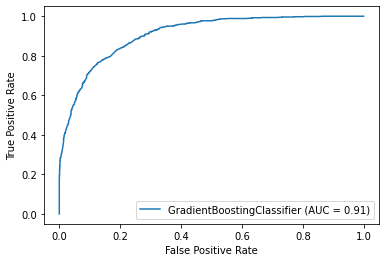

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, plot_roc_curve

plot_roc_curve(boost1,X_test,y_test,response_method='predict_proba')
plt.show()

Podemos observar que el modelo tiene un 0.9 de probabilidad de distinguir correctamente las clases.

### Recall

In [30]:
recall_score(y_test, y_pred)

0.6007653061224489

### Precision

In [31]:
precision_score(y_test,y_pred)

0.7671009771986971

### Accuracy

In [32]:
accuracy_score(y_test, y_pred) 

0.8599938593797973

### Matriz de confusion

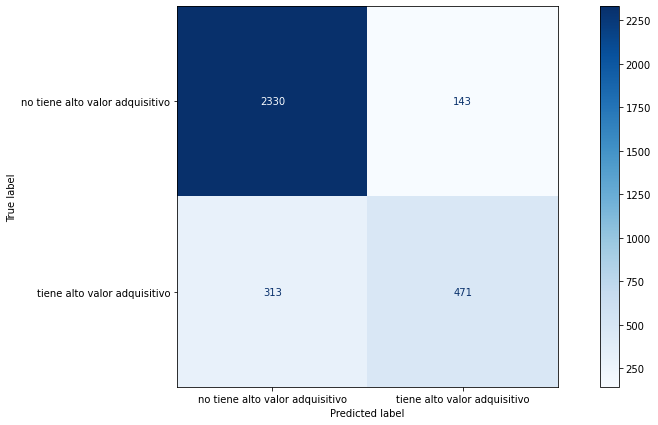

In [33]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(15, 7))
plt.grid(False)
plot_confusion_matrix(
    boost1, X_test, y_test, cmap=plt.cm.Blues, display_labels=['no tiene alto valor adquisitivo', 'tiene alto valor adquisitivo'], ax=ax
)

plt.show()

## Prediccion sobre el data set de hold out

Aplicamos la ingenieria de features correspondiente al primer modelo de Boosting y luego predecimos.

In [41]:
from preprocessing import prepararSetDeHoldOutBoosting

In [42]:
aux = final_df.copy()

final_df_copy = prepararSetDeHoldOutBoosting(final_df,meanEncoding)
ho_prediction = boost1.predict(final_df_copy)

aux['tiene_alto_valor_adquisitivo'] = ho_prediction
aux.to_csv('predicciones/boosting.csv')